In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [218]:
import csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer

csvFile = '/Users/aleksey/Main/MachineLearning/moving-classification/gyroscope_data.csv'
numberOfMeasurementsPerSample = 15


csvFileReader = csv.reader(open(csvFile), delimiter=',')
linesWithoutHeader = ([x for x in csvFileReader])[1:]

def removeLastColumn(lines):
    return [line[:-1] for line in lines]

def prepareDictionaryWithLabelsToSortedMeasurements(lines):
    def filterLinesWithLabel(label, lines):
        return [line for line in lines if line[-1] == label]

    def sortByTime(lines):
        return sorted(lines, key=lambda line: line[-2], reverse=False)
    
    def findUniqLabes(lines):
        return set([line[-1] for line in lines])
    
    labesToFeatures = {}
    
    for label in findUniqLabes(lines):
        labesToFeatures[label] = removeLastColumn(filterLinesWithLabel(label, lines))
    
    return labesToFeatures

labelsToMeasurements = prepareDictionaryWithLabelsToSortedMeasurements(linesWithoutHeader)                                                   

def prepareData(labelsToMeasurements, numberOfMeasurementsPerSample):
    def createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample):
        numberOfSamples = len(measurements) // numberOfMeasurementsPerSample
        
        samples = np.zeros((numberOfSamples, numberOfMeasurementsPerSample, len(measurements[0])))
        
        for i in range(0, numberOfSamples):
            measurementsPerSample = measurements[i * numberOfMeasurementsPerSample : (i + 1) * numberOfMeasurementsPerSample]
            samples[i] = np.array(measurementsPerSample)
        return samples
    
    samples = []
    targets = []
    
    for label, measurements in labelsToMeasurements.items():
        samplesOfLabel = createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample)
        
        samples.extend(samplesOfLabel)
        targets.extend(np.full((samplesOfLabel.shape[0]), label))
    
    return np.array(samples), np.array(targets)

def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = prepareData(labelsToMeasurements, numberOfMeasurementsPerSample)
samples, targets = shuffleSamplesAndTargets(samples, targets)
targets = LabelBinarizer().fit_transform(targets)

print(samples.shape)
print(targets.shape)

(4199, 15, 6)
(4199, 3)


In [219]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(2519, 15, 6)
(2519, 3)
(839, 15, 6)
(839, 3)
(839, 15, 6)
(839, 3)


In [220]:
val_labels

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [235]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='tanh',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 3, activation='tanh'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(3, activation='tanh'))

In [232]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse',
              metrics=['accuracy'])

In [237]:
history = model.fit(train_data,
                    train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 2519 samples, validate on 839 samples
Epoch 1/100
2519/2519 [==============================] - 5s 2ms/step - loss: 0.2445 - acc: 0.5026 - val_loss: 0.1726 - val_acc: 0.6257
Epoch 2/100
2519/2519 [==============================] - 0s 100us/step - loss: 0.1717 - acc: 0.6272 - val_loss: 0.1556 - val_acc: 0.6663
Epoch 3/100
2519/2519 [==============================] - 0s 98us/step - loss: 0.1559 - acc: 0.6689 - val_loss: 0.1470 - val_acc: 0.6675
Epoch 4/100
2519/2519 [==============================] - 0s 98us/step - loss: 0.1482 - acc: 0.6844 - val_loss: 0.1464 - val_acc: 0.6925
Epoch 5/100
2519/2519 [==============================] - 0s 103us/step - loss: 0.1408 - acc: 0.7054 - val_loss: 0.1371 - val_acc: 0.7056
Epoch 6/100
2519/2519 [==============================] - 0s 95us/step - loss: 0.1353 - acc: 0.7189 - val_loss: 0.1354 - val_acc: 0.7223
Epoch 7/100
2519/2519 [==============================] - 0s 94us/step - loss: 0.1306 - acc: 0.7332 - val_loss: 0.1336 - val_acc: 0.7092


Epoch 60/100
2519/2519 [==============================] - 0s 110us/step - loss: 0.0733 - acc: 0.8618 - val_loss: 0.1056 - val_acc: 0.7831
Epoch 61/100
2519/2519 [==============================] - 0s 107us/step - loss: 0.0737 - acc: 0.8642 - val_loss: 0.1067 - val_acc: 0.7771
Epoch 62/100
2519/2519 [==============================] - 0s 116us/step - loss: 0.0729 - acc: 0.8678 - val_loss: 0.1083 - val_acc: 0.7735
Epoch 63/100
2519/2519 [==============================] - 0s 111us/step - loss: 0.0731 - acc: 0.8634 - val_loss: 0.1113 - val_acc: 0.7747
Epoch 64/100
2519/2519 [==============================] - 0s 110us/step - loss: 0.0722 - acc: 0.8662 - val_loss: 0.1064 - val_acc: 0.7831
Epoch 65/100
2519/2519 [==============================] - 0s 99us/step - loss: 0.0703 - acc: 0.8777 - val_loss: 0.1082 - val_acc: 0.7795
Epoch 66/100
2519/2519 [==============================] - 0s 113us/step - loss: 0.0701 - acc: 0.8722 - val_loss: 0.1074 - val_acc: 0.7795
Epoch 67/100
2519/2519 [===========

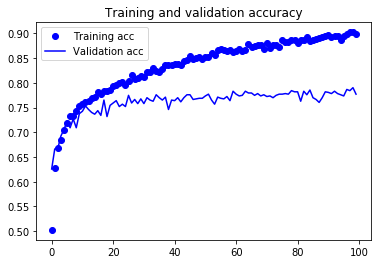

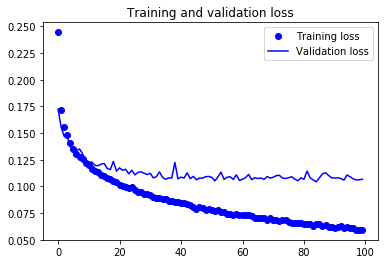

In [238]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [239]:
model.evaluate(test_data, test_labels)

839/839 [==============================] - 0s 58us/step


[0.10201889069815287, 0.7890345649582837]